In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/Users/Aaron-MAC/Development/Kaggle/Santander")
import pandas as pd
import numpy as np
from modules.pre_process import *
from modules.get_data import *
import matplotlib.pyplot as plt
import cPickle as pickle
import xgboost as xgb
%matplotlib inline

In [2]:
cache = pd.read_csv("data/train_ver2.csv").fillna(-2.)

/Users/Aaron-MAC/anaconda/envs/mlp/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
"""
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train = mas.fit_transform(X_train)
X_test = mas.transform(X_test)
"""

In [13]:
X_train, y_train = feed_training_data(year=2015, month=5, cache=cache, mul_y=False)
X_test = feed_test_data(year=2016, month=5, cache=cache)
X_test_unred = X_test.copy()
test_set = get_test_data(year=2016, month=5, cache=cache)

In [14]:
X_train = X_train[:, 24:]
X_test = X_test[:, 24:]

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc = enc.fit(X_test+2)
X_train = enc.transform(X_train+2)
X_test = enc.transform(X_test+2)

In [16]:
X_train = X_train.todense()
X_test = X_test.todense()

In [20]:
from sklearn.cluster import MiniBatchKMeans
num_cluster = 100
k_means = MiniBatchKMeans(n_clusters=num_cluster, reassignment_ratio=0.1)
k_means = k_means.fit(X_test)

train_class = k_means.predict(X_train)
test_class= k_means.predict(X_test)

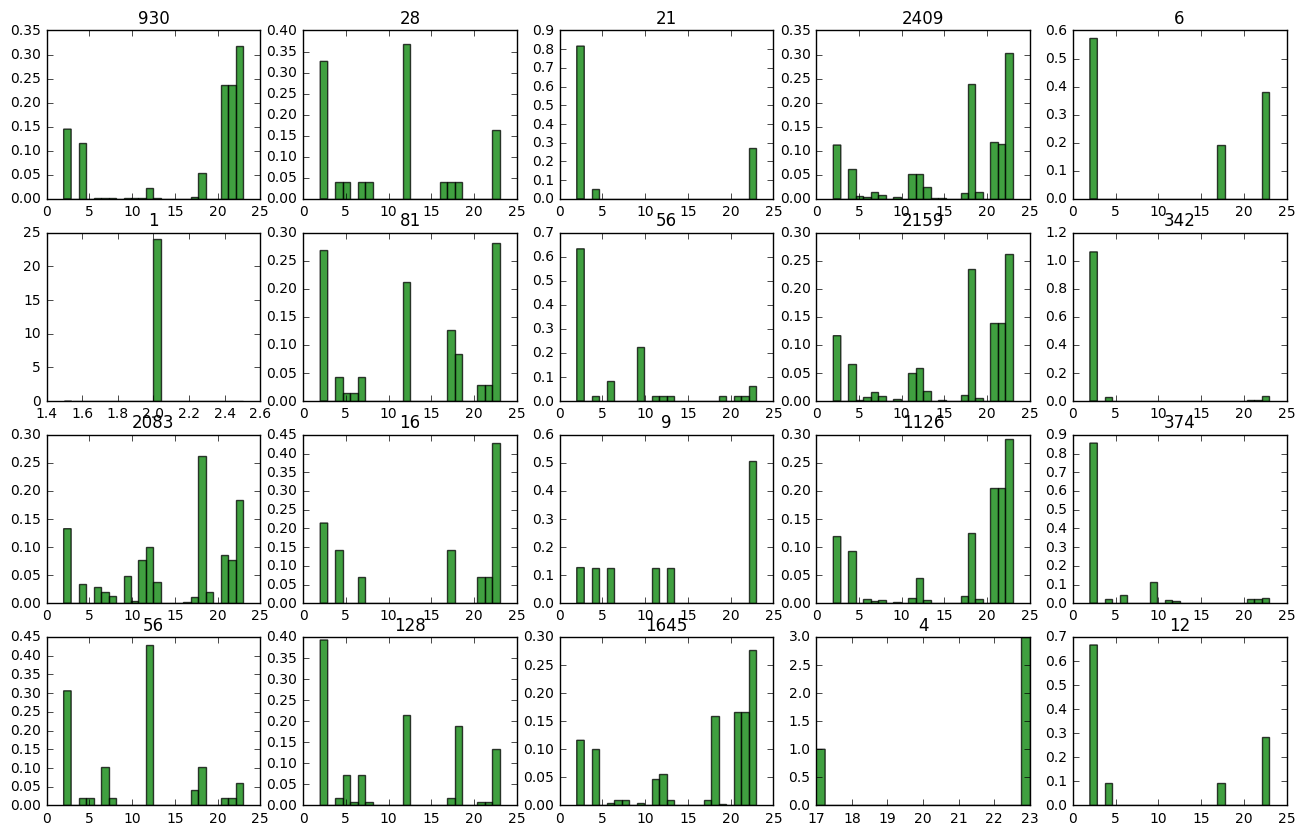

In [21]:
fig = plt.figure(figsize=(16,10))

for i in range(20):
    x = y_train[train_class==i]
    #x = np.random.randint(0,24,size=x.shape)
    ax = fig.add_subplot(4,5,i+1)
    ax.set_title(len(x))
    n, bins, patches = ax.hist(x, 24, normed=1, facecolor='green', alpha=0.75)

In [12]:
arr = []
for i in range(24):
    sel = y_train==i
    
    if len(X_train[sel])>0:
        arr.append(X_train[sel].mean(0))
feature_sel = np.array(arr).std(0)

X_train = X_train[:, feature_sel[0]>0.05]
X_test = X_test[:, feature_sel[0]>0.05]

In [106]:
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.05
    param['max_depth'] = 3
    param['silent'] = 0
    param['num_class'] = 24
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)	
    return model

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(verbose=True, n_estimators=60)
model = model.fit(X_train_comb, y_train)
predict = model.predict_proba(X_test_comb)
predict = np.hstack([np.zeros((len(predict),2)), predict])

      Iter       Train Loss   Remaining Time 
         1       72856.8323            2.95m
         2       66112.1839            2.90m
         3       61368.5337            2.92m
         4       57882.1827            2.88m
         5       55151.3934            2.93m
         6       52945.9490            2.96m
         7       51139.8410            2.86m
         8       49645.0368            2.82m
         9       48368.9228            2.78m
        10       47297.6252            2.75m
        20       41670.0845            2.22m
        30       39534.3045            1.63m
        40       38429.2436            1.08m
        50       39751.8143           32.11s
        60       39204.9440            0.00s


In [24]:
mask = X_test_unred[:, :24]==0
predict = predict*mask

In [25]:
f = open("outputs/test_4.csv", 'w')
f.write("ncodpers,added_products\n")

user_id = test_set['ncodpers']

count = np.bincount(y_train)
ban_list = np.argwhere(count<count.max()*0.005)[:,0]

print ban_list
print len(predict)

for idx,r in enumerate(predict):
    order = [i[0] for i in sorted(enumerate(r), key=lambda x:x[1], reverse=True)]
    order = [x for x in order if x not in ban_list]
    select = order[:min(7,len(order))]
      
    f.write(str(user_id[idx])+","+(" ".join([products[s] for s in select]))+'\n')
f.close()

[ 0  1  3 10 14 15 16 20]
931453


In [26]:
from modules.evaluation import *
eval_submission('test_4.csv', year=2016, month=5, cache=cache)

0.06462052827212064

(30445, 74)

In [9]:
from sklearn.neural_network import BernoulliRBM

rbm1 = BernoulliRBM(n_components=20, verbose=True, learning_rate=1e-2, n_iter=10)
rbm1 = rbm1.fit(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -26.12, time = 17.46s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -25.21, time = 21.24s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -24.33, time = 21.38s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -24.92, time = 21.23s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -23.81, time = 21.43s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -24.10, time = 21.66s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -22.10, time = 20.98s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -22.72, time = 20.94s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -21.52, time = 20.92s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -22.16, time = 20.85s


In [10]:
X_train_rbm = rbm.transform(X_train)
X_test_rbm = rbm.transform(X_test)

In [14]:
X_train_comb = np.hstack([X_train_rbm, X_train])
X_test_comb = np.hstack([X_test_rbm, X_test])

In [142]:
X_train_rbm = rbm.transform(X_train)
X_test_rbm = rbm.transform(X_test)

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.)
model = model.fit(X_train_comb, y_train)
predict = model.predict_proba(X_test_comb)
predict = np.hstack([np.zeros((len(predict), 2)), predict])

In [7]:
from sklearn import svm

clf = svm.SVC(verbose=True)
clf.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [ ]:
predict = clf.decision_function(X_test)

In [ ]:
print predict